In [6]:
!unzip calmscope_black_white -d /content

unzip:  cannot find or open calmscope_black_white, calmscope_black_white.zip or calmscope_black_white.ZIP.


In [7]:
!pip install roboflow -q

^C
Traceback (most recent call last):
  File "/opt/miniconda3/envs/tf-m2/lib/python3.10/site-packages/pip/_internal/cli/base_command.py", line 107, in _run_wrapper
    status = _inner_run()
  File "/opt/miniconda3/envs/tf-m2/lib/python3.10/site-packages/pip/_internal/cli/base_command.py", line 98, in _inner_run
    return self.run(options, args)
  File "/opt/miniconda3/envs/tf-m2/lib/python3.10/site-packages/pip/_internal/cli/req_command.py", line 85, in wrapper
    return func(self, options, args)
  File "/opt/miniconda3/envs/tf-m2/lib/python3.10/site-packages/pip/_internal/commands/install.py", line 388, in run
    requirement_set = resolver.resolve(
  File "/opt/miniconda3/envs/tf-m2/lib/python3.10/site-packages/pip/_internal/resolution/resolvelib/resolver.py", line 99, in resolve
    result = self._result = resolver.resolve(
  File "/opt/miniconda3/envs/tf-m2/lib/python3.10/site-packages/pip/_vendor/resolvelib/resolvers/resolution.py", line 601, in resolve
    state = resolution.re

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import pathlib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import os
import shutil
from pathlib import Path

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

from tqdm.auto import tqdm
import yaml

In [ ]:
# Configuration
BATCH_SIZE = 32 # Increased slightly for stability
IMG_SIZE = (128, 128) # Reduced from 224 for Custom CNN (faster, less overfitting)
DATA_DIR = "calmscope_black_white" # Your dataset folder
SEED = 42

# --- Simplified Data Loader ---
def load_image_paths(data_dir):
    data_dir_path = pathlib.Path(data_dir)
    # Recursively search for images in all subdirectories
    image_paths = list(data_dir_path.glob('**/*.jpg')) + \
                  list(data_dir_path.glob('**/*.png')) + \
                  list(data_dir_path.glob('**/*.jpeg'))
    image_paths = [str(path) for path in image_paths]

    labels = []
    final_paths = []

    for path in image_paths:
        filename = os.path.basename(path).lower()
        parent_folder = pathlib.Path(path).parent.name.lower()
        # Accept label from either filename or parent folder
        if "negative" in filename or parent_folder == "negative":
            labels.append(0)
            final_paths.append(path)
        elif "positive" in filename or parent_folder == "positive":
            labels.append(1)
            final_paths.append(path)

    if not final_paths:
        print(f"Warning: No images found in '{data_dir}' matching 'positive' or 'negative'.")

    return np.array(final_paths), np.array(labels)

# Load data
paths, labels = load_image_paths(DATA_DIR)

# Split logic (80% Train, 20% Val) - Simplified
from sklearn.model_selection import train_test_split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    paths, labels, test_size=0.2, random_state=SEED, stratify=labels
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")

# --- TF Dataset Pipeline (Fast & Clean) ---
def process_path(path, label):
    # Read file
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3) # Ensure decoding as color
    img = tf.image.rgb_to_grayscale(img) # Convert to grayscale
    # Resize
    img = tf.image.resize(img, IMG_SIZE)
    return img, label

def create_dataset(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(buffer_size=1000, seed=SEED)

    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_paths, train_labels, training=True)
val_ds = create_dataset(val_paths, val_labels)

Training samples: 3740
Validation samples: 936


In [ ]:
IMG_SIZE = 224  # kalau GPU mepet bisa turunkan ke 160 atau 128

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [ ]:
class HybridDepressionDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["img_path"]
        label = int(row["label"])

        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

In [ ]:
def build_model(num_classes=2, dropout_p=0.4):
    model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
    in_features = model.classifier[1].in_features

    model.classifier[1] = nn.Sequential(
        nn.Dropout(p=dropout_p),
        nn.Linear(in_features, num_classes)
    )
    return model


In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            outputs = model(images)
            loss = criterion(outputs, labels)

        if device == "cuda":
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
NUM_EPOCHS = 12      # boleh kamu ubah
BATCH_SIZE = 32     # turunkan kalau OOM (16 / 8)
N_SPLITS   = 5      # jumlah fold
DEVICE = 'cuda'

hybrid_df = pd.DataFrame({
    "img_path": paths,
    "label": labels
})

print(f"Hybrid DataFrame created with {len(hybrid_df)} entries.")
display(hybrid_df.head())

labels_all = hybrid_df["label"].values
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

fold_histories = []       # list of dict: train_loss, val_loss, train_acc, val_acc
fold_best_accs = []       # best val acc tiap fold
best_states    = []       # state_dict terbaik tiap fold
fold_splits    = []       # simpan index, buat confusion matrix nanti

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels_all)), labels_all)):
    print(f"\n===== Fold {fold + 1}/{N_SPLITS} =====")

    train_df = hybrid_df.iloc[train_idx].reset_index(drop=True)
    val_df   = hybrid_df.iloc[val_idx].reset_index(drop=True)

    train_dataset = HybridDepressionDataset(train_df, transform=train_transform)
    val_dataset   = HybridDepressionDataset(val_df,   transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=4, pin_memory=True)

    model = build_model(num_classes=2, dropout_p=0.4).to(DEVICE)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    best_val_acc = 0.0
    best_state = None

    for epoch in range(NUM_EPOCHS):
        print(f"\nFold {fold+1} - Epoch {epoch+1}/{NUM_EPOCHS}")
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, DEVICE)
        val_loss, val_acc     = evaluate(model, val_loader, criterion, DEVICE)
        scheduler.step()

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
        print(f"Val   loss: {val_loss:.4f} | Val   acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

    print(f"Best val acc for fold {fold+1}: {best_val_acc:.4f}")

    fold_histories.append(history)
    fold_best_accs.append(best_val_acc)
    best_states.append(best_state)
    fold_splits.append((train_idx, val_idx))

print("\n===== Cross-validation result =====")
for i, acc in enumerate(fold_best_accs):
    print(f"Fold {i+1}: {acc:.4f}")
print(f"Mean val acc: {np.mean(fold_best_accs):.4f} +/- {np.std(fold_best_accs):.4f}")

Hybrid DataFrame created with 4676 entries.


,img_path,label
0,calmscope_black_white/train/images/Positive-12...,1
1,calmscope_black_white/train/images/Negative-37...,0
2,calmscope_black_white/train/images/Positive-35...,1
3,calmscope_black_white/train/images/Negative-16...,0
4,calmscope_black_white/train/images/Negative-14...,0



===== Fold 1/5 =====
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 174MB/s]



Fold 1 - Epoch 1/12


/tmp/ipython-input-2433639994.py:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))


  0%|          | 0/117 [00:00<?, ?it/s]

/tmp/ipython-input-3596561169.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.6399 | Train acc: 0.6131
Val   loss: 0.5808 | Val   acc: 0.6880

Fold 1 - Epoch 2/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.5497 | Train acc: 0.7235
Val   loss: 0.5400 | Val   acc: 0.7372

Fold 1 - Epoch 3/12


  0%|          | 0/117 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>    
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
if w.is_alive():
      self._shutdown_workers() 
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():
^ ^ Exception ignored in: Exception ignored in: ^ <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100><function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>^ 

^Traceback (most recent

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.4817 | Train acc: 0.7818
Val   loss: 0.5159 | Val   acc: 0.7479

Fold 1 - Epoch 4/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.4299 | Train acc: 0.8249
Val   loss: 0.4737 | Val   acc: 0.7906

Fold 1 - Epoch 5/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3916 | Train acc: 0.8529
Val   loss: 0.4576 | Val   acc: 0.7927

Fold 1 - Epoch 6/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3721 | Train acc: 0.8553
Val   loss: 0.4528 | Val   acc: 0.8056

Fold 1 - Epoch 7/12


  0%|          | 0/117 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100><function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>

Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>

self._shutdown_workers()      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Traceback (most recent call last):
    
self._shutdo

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3446 | Train acc: 0.8727
Val   loss: 0.4517 | Val   acc: 0.8098

Fold 1 - Epoch 8/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3338 | Train acc: 0.8821
Val   loss: 0.4654 | Val   acc: 0.7959

Fold 1 - Epoch 9/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3143 | Train acc: 0.8976
Val   loss: 0.4584 | Val   acc: 0.7991

Fold 1 - Epoch 10/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3120 | Train acc: 0.8952
Val   loss: 0.4629 | Val   acc: 0.8013

Fold 1 - Epoch 11/12


  0%|          | 0/117 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100><function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100><function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1600, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.12/threading.py", line 1146, in join


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
    raise RuntimeError("cannot join current thread")
RuntimeError: c

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.2948 | Train acc: 0.9064
Val   loss: 0.4609 | Val   acc: 0.8002

Fold 1 - Epoch 12/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.2940 | Train acc: 0.9059
Val   loss: 0.4630 | Val   acc: 0.7970
Best val acc for fold 1: 0.8098

===== Fold 2/5 =====

Fold 2 - Epoch 1/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.6440 | Train acc: 0.6210
Val   loss: 0.5773 | Val   acc: 0.6952

Fold 2 - Epoch 2/12


  0%|          | 0/117 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.5424 | Train acc: 0.7281
Val   loss: 0.5324 | Val   acc: 0.7369

Fold 2 - Epoch 3/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.4799 | Train acc: 0.7918
Val   loss: 0.4974 | Val   acc: 0.7604

Fold 2 - Epoch 4/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.4392 | Train acc: 0.8148
Val   loss: 0.4787 | Val   acc: 0.7765

Fold 2 - Epoch 5/12


  0%|          | 0/117 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.4073 | Train acc: 0.8401
Val   loss: 0.4616 | Val   acc: 0.7957

Fold 2 - Epoch 6/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3768 | Train acc: 0.8549
Val   loss: 0.4563 | Val   acc: 0.8160

Fold 2 - Epoch 7/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3468 | Train acc: 0.8682
Val   loss: 0.4544 | Val   acc: 0.8225

Fold 2 - Epoch 8/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3297 | Train acc: 0.8867
Val   loss: 0.4536 | Val   acc: 0.8203

Fold 2 - Epoch 9/12


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Exception ignored in: Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100><function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


    self._shutdown_workers()    Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/loc

  0%|          | 0/117 [00:00<?, ?it/s]

     ^^ assert self._parent_pid == os.getpid(), 'can only test a child process'^ ^
 ^
  
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
          assert self._parent_pid == os.getpid(), 'can only test a child process'   ^assert self._parent_pid == os.getpid(), 'can only test a child process'
 ^
  ^   ^  ^   ^       ^  ^^ ^  ^  ^  ^ ^ ^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^AssertionError^^^: ^^^^^can only test a child process^^^^^
^^^^^
AssertionError^^: ^can only test a child process^^^
^^^^^^^

AssertionErrorAssertionError: : can only test a child processcan only test a child process



  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3146 | Train acc: 0.8944
Val   loss: 0.4669 | Val   acc: 0.8075

Fold 2 - Epoch 10/12


  0%|          | 0/117 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Traceback (most recent call last):
    self._shutdown_workers()    self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

self._shutdown_workers()
  

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3137 | Train acc: 0.8917
Val   loss: 0.4515 | Val   acc: 0.8225

Fold 2 - Epoch 11/12


  0%|          | 0/117 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.2983 | Train acc: 0.9083
Val   loss: 0.4517 | Val   acc: 0.8267

Fold 2 - Epoch 12/12


  0%|          | 0/117 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100><function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100><function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>


<function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
              File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()self._shutdown_workers()self._shutdown_workers()
   

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.2950 | Train acc: 0.9070
Val   loss: 0.4558 | Val   acc: 0.8257
Best val acc for fold 2: 0.8267

===== Fold 3/5 =====

Fold 3 - Epoch 1/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.6378 | Train acc: 0.6284
Val   loss: 0.5571 | Val   acc: 0.7005

Fold 3 - Epoch 2/12


  0%|          | 0/117 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.5460 | Train acc: 0.7212
Val   loss: 0.4908 | Val   acc: 0.7668

Fold 3 - Epoch 3/12


  0%|          | 0/117 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100><function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>    

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    
self._s

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.4918 | Train acc: 0.7781
Val   loss: 0.4756 | Val   acc: 0.7775

Fold 3 - Epoch 4/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.4436 | Train acc: 0.8110
Val   loss: 0.4517 | Val   acc: 0.8107

Fold 3 - Epoch 5/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.4025 | Train acc: 0.8428
Val   loss: 0.4434 | Val   acc: 0.7936

Fold 3 - Epoch 6/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3728 | Train acc: 0.8524
Val   loss: 0.4418 | Val   acc: 0.8032

Fold 3 - Epoch 7/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3461 | Train acc: 0.8786
Val   loss: 0.4405 | Val   acc: 0.8043

Fold 3 - Epoch 8/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3320 | Train acc: 0.8891
Val   loss: 0.4464 | Val   acc: 0.8075

Fold 3 - Epoch 9/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3120 | Train acc: 0.8982
Val   loss: 0.4546 | Val   acc: 0.8118

Fold 3 - Epoch 10/12


  0%|          | 0/117 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100><function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100><function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>Exception ignored in: 


Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-pa

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3035 | Train acc: 0.8998
Val   loss: 0.4432 | Val   acc: 0.8160

Fold 3 - Epoch 11/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.2999 | Train acc: 0.9024
Val   loss: 0.4498 | Val   acc: 0.8171

Fold 3 - Epoch 12/12


  0%|          | 0/117 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.2902 | Train acc: 0.9062
Val   loss: 0.4526 | Val   acc: 0.8150
Best val acc for fold 3: 0.8171

===== Fold 4/5 =====

Fold 4 - Epoch 1/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.6284 | Train acc: 0.6316
Val   loss: 0.5842 | Val   acc: 0.6963

Fold 4 - Epoch 2/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.5372 | Train acc: 0.7338
Val   loss: 0.5225 | Val   acc: 0.7572

Fold 4 - Epoch 3/12


  0%|          | 0/117 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    Traceback (most recent call last):
    self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      File "/usr/loc

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.4817 | Train acc: 0.7824
Val   loss: 0.4734 | Val   acc: 0.7947

Fold 4 - Epoch 4/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.4352 | Train acc: 0.8188
Val   loss: 0.4626 | Val   acc: 0.7957

Fold 4 - Epoch 5/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3945 | Train acc: 0.8426
Val   loss: 0.4658 | Val   acc: 0.7914

Fold 4 - Epoch 6/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3787 | Train acc: 0.8540
Val   loss: 0.4515 | Val   acc: 0.8171

Fold 4 - Epoch 7/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3560 | Train acc: 0.8709
Val   loss: 0.4476 | Val   acc: 0.8171

Fold 4 - Epoch 8/12


  0%|          | 0/117 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>Traceback (most recent call last):
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in:     if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
    self._shutdown_workers() 
self._shutdown_workers()  Trac

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3296 | Train acc: 0.8827
Val   loss: 0.4542 | Val   acc: 0.8128

Fold 4 - Epoch 9/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3222 | Train acc: 0.8912
Val   loss: 0.4581 | Val   acc: 0.8032

Fold 4 - Epoch 10/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3059 | Train acc: 0.8992
Val   loss: 0.4591 | Val   acc: 0.8053

Fold 4 - Epoch 11/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3033 | Train acc: 0.9003
Val   loss: 0.4618 | Val   acc: 0.8096

Fold 4 - Epoch 12/12


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>Traceback (most recent call last):

Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
        self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

      File "/usr/local/lib/python3.12/dist-packages/tor

  0%|          | 0/117 [00:00<?, ?it/s]

     

assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^         ^ assert self._parent_pid == os.getpid(), 'can only test a child process' assert self._parent_pid == os.getpid(), 'can only test a child process'
^
   ^ ^  ^  ^  ^   ^    ^   ^  ^ ^  ^^ ^ ^ ^^^^ ^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^AssertionError^^^: ^can only test a child process^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^AssertionError
AssertionError: ^can only test a child process: ^
can only test a child process
AssertionError
: can only test a child process


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.2970 | Train acc: 0.9070
Val   loss: 0.4629 | Val   acc: 0.8043
Best val acc for fold 4: 0.8171

===== Fold 5/5 =====

Fold 5 - Epoch 1/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.6370 | Train acc: 0.6212
Val   loss: 0.5771 | Val   acc: 0.6984

Fold 5 - Epoch 2/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.5507 | Train acc: 0.7215
Val   loss: 0.5342 | Val   acc: 0.7316

Fold 5 - Epoch 3/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.4937 | Train acc: 0.7715
Val   loss: 0.4747 | Val   acc: 0.7947

Fold 5 - Epoch 4/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.4466 | Train acc: 0.8067
Val   loss: 0.4578 | Val   acc: 0.7968

Fold 5 - Epoch 5/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.4144 | Train acc: 0.8249
Val   loss: 0.4382 | Val   acc: 0.8096

Fold 5 - Epoch 6/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3866 | Train acc: 0.8474
Val   loss: 0.4445 | Val   acc: 0.8150

Fold 5 - Epoch 7/12


  0%|          | 0/117 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>    
Traceback (most recent call last):
self._shutdown_workers()Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba065f5f100>      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

self._shutdown_workers()if w.is_alive():Traceback (most recent call last):

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

       File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
     

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3660 | Train acc: 0.8549
Val   loss: 0.4219 | Val   acc: 0.8267

Fold 5 - Epoch 8/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3476 | Train acc: 0.8744
Val   loss: 0.4257 | Val   acc: 0.8246

Fold 5 - Epoch 9/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3267 | Train acc: 0.8859
Val   loss: 0.4231 | Val   acc: 0.8214

Fold 5 - Epoch 10/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3293 | Train acc: 0.8851
Val   loss: 0.4287 | Val   acc: 0.8171

Fold 5 - Epoch 11/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3096 | Train acc: 0.8987
Val   loss: 0.4283 | Val   acc: 0.8225

Fold 5 - Epoch 12/12


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.3139 | Train acc: 0.8936
Val   loss: 0.4216 | Val   acc: 0.8235
Best val acc for fold 5: 0.8267

===== Cross-validation result =====
Fold 1: 0.8098
Fold 2: 0.8267
Fold 3: 0.8171
Fold 4: 0.8171
Fold 5: 0.8267
Mean val acc: 0.8195 +/- 0.0065


Best fold index (0-based): 1
Best fold val acc: 0.8267379679144385


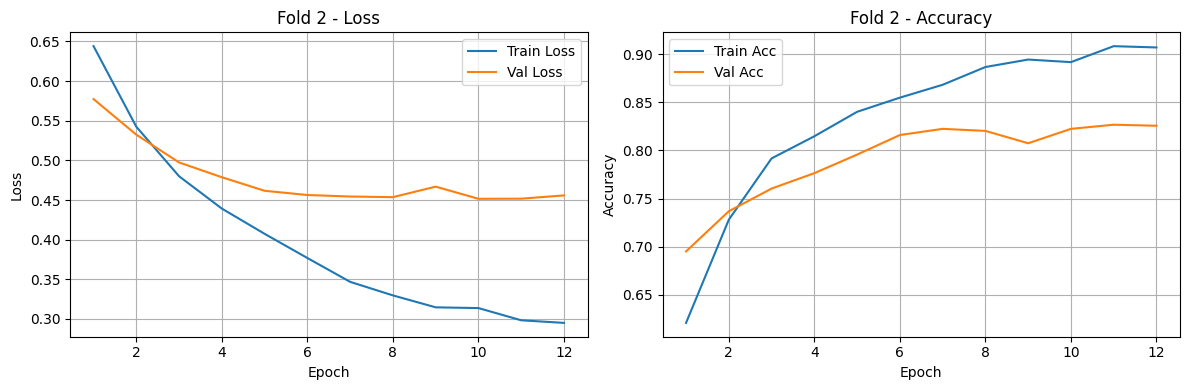

In [ ]:
best_fold = int(np.argmax(fold_best_accs))
print("Best fold index (0-based):", best_fold)
print("Best fold val acc:", fold_best_accs[best_fold])

best_history = fold_histories[best_fold]

epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, best_history["train_loss"], label="Train Loss")
plt.plot(epochs, best_history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Fold {best_fold+1} - Loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, best_history["train_acc"], label="Train Acc")
plt.plot(epochs, best_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Fold {best_fold+1} - Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Rebuild val set untuk fold terbaik
_, val_idx = fold_splits[best_fold]
val_df_best = hybrid_df.iloc[val_idx].reset_index(drop=True)

val_dataset_best = HybridDepressionDataset(val_df_best, transform=val_transform)
val_loader_best  = DataLoader(val_dataset_best, batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=4, pin_memory=True)

# Load model dengan weight terbaik fold tsb
model_best = build_model(num_classes=2, dropout_p=0.4).to(DEVICE)
model_best.load_state_dict(best_states[best_fold])
model_best.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(val_loader_best):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model_best(images)
        _, preds = outputs.max(1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)

print("Classification report:")
print(classification_report(all_labels, all_preds, target_names=["neutral", "depressed"]))


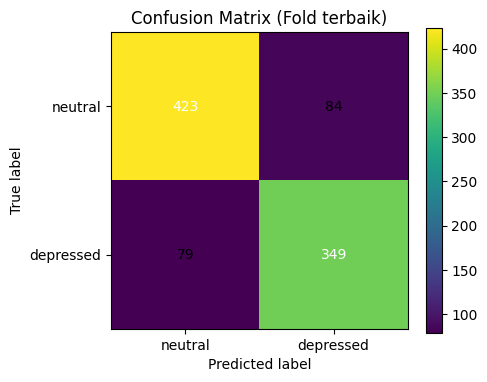

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
classes = ["neutral", "depressed"]

plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model, 'efficientnetb0.pt')

In [ ]:
# Rebuild val set untuk fold terbaik
_, val_idx = fold_splits[best_fold]
val_df_best = hybrid_df.iloc[val_idx].reset_index(drop=True)

val_dataset_best = HybridDepressionDataset(val_df_best, transform=val_transform)
val_loader_best  = DataLoader(val_dataset_best, batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=4, pin_memory=True)

# Load model dengan weight terbaik fold tsb
model_best = build_model(num_classes=2, dropout_p=0.4).to(DEVICE)
model_best.load_state_dict(best_states[best_fold])
model_best.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(val_loader_best):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model_best(images)
        _, preds = outputs.max(1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)

print("Classification report:")
print(classification_report(all_labels, all_preds, target_names=["neutral", "depressed"]))


  0%|          | 0/30 [00:00<?, ?it/s]

Classification report:
              precision    recall  f1-score   support

     neutral       0.84      0.83      0.84       507
   depressed       0.81      0.82      0.81       428

    accuracy                           0.83       935
   macro avg       0.82      0.82      0.82       935
weighted avg       0.83      0.83      0.83       935



In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=238fa878c160f8bb1c9396189a743e179527f076a5f794d0c86fd4df8e7a0a25
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


Randomly selected: ['Negative-5249_jpg.rf.f6b1d826edac3cf0c49505ca41945b4b.jpg', 'Positive-1448_jpg.rf.4d3b9f6189c51b6caea48ac18e5e45c0.jpg', 'Positive-2850_jpg.rf.47e0b20df2667d8f48faa9e3b6a61f45.jpg']


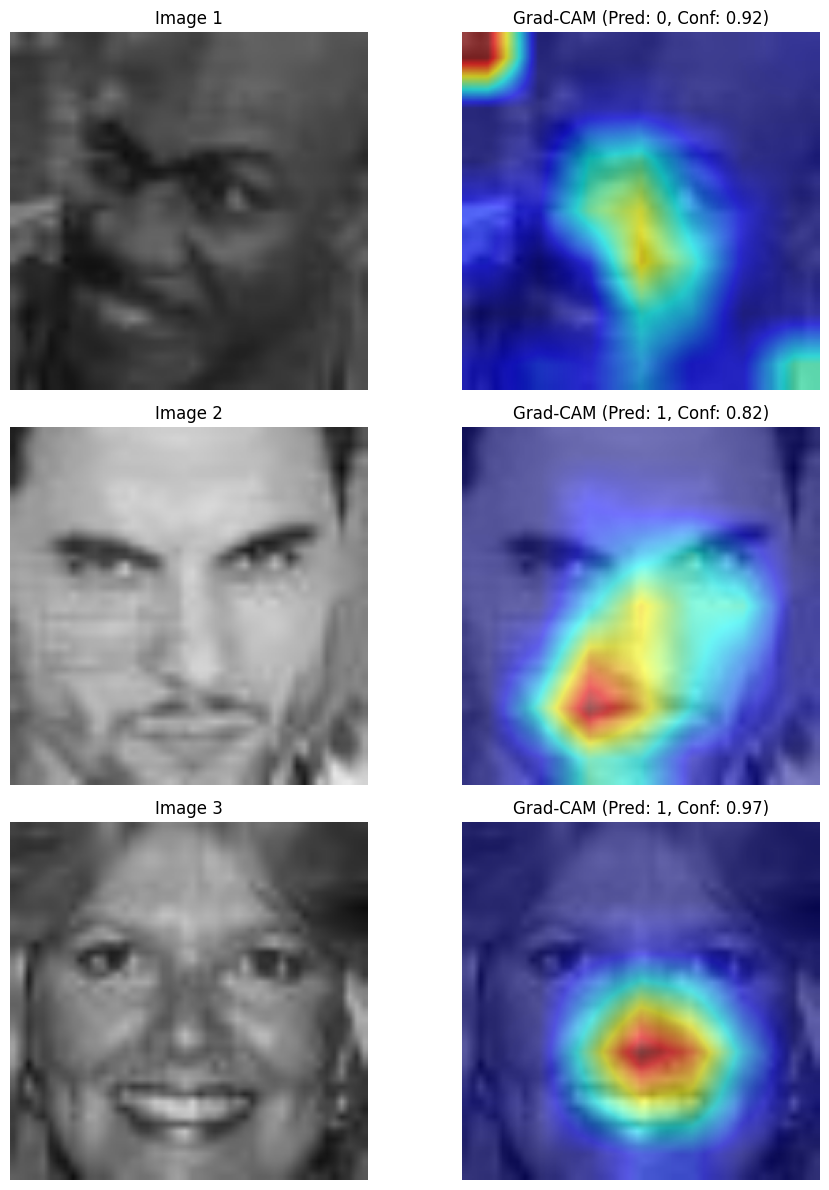

In [ ]:
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms

# --- 1. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224

# --- 2. PREPROCESSING (Matched to your `val_transform`) ---
# We use standard PyTorch transforms here to ensure exact consistency with your training
preprocess = transforms.Compose([
    transforms.ToPILImage(),             # Convert numpy image to PIL
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),     # Matches your val_transform
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def get_image_tensor(image_path):
    img = cv2.imread(image_path)
    if img is None: return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Ensure RGB

    # Apply the transform directly
    tensor = preprocess(img)
    return tensor.unsqueeze(0).to(device) # Add batch dim -> (1, 3, 224, 224)

# --- 3. LOAD MODEL & DATA ---
try:
    # We use weights_only=False because you trust your own file
    checkpoint = torch.load('efficientnetb0.h5', map_location=device, weights_only=False)

    # Handle if it's a full model vs just weights
    if isinstance(checkpoint, torch.nn.Module):
        model = checkpoint
    else:
        # Initialize architecture first
        model = torchvision.models.efficientnet_b0(pretrained=False)
        # Adjust classifier if needed (e.g., if you have 2 classes)
        # model.classifier[1] = torch.nn.Linear(1280, 2)

        if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
            model.load_state_dict(checkpoint['state_dict'])
        else:
            model.load_state_dict(checkpoint)

except Exception as e:
    print(f"❌ Critical Model Load Error: {e}")
    exit()

model.to(device)
model.eval()

def preprocess_image(image_path):
    # Load and Resize
    img = cv2.imread(image_path)
    if img is None: return None, None, None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Prepare for Visualization (float 0-1)
    img_float = np.float32(img_resized) / 255.0

    # Prepare for Model (Normalize)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_norm = (img_float - mean) / std

    # To Tensor
    input_tensor = torch.from_numpy(img_norm).permute(2, 0, 1).unsqueeze(0).float().to(device)
    return img_resized, img_float, input_tensor

# --- 4. MAIN EXECUTION (RANDOM PICK) ---

# A. Find all images
folder_path = os.path.join('calmscope_black_white', 'test', 'images')
all_images = glob.glob(os.path.join(folder_path, '*.jpg')) # Add *.png if needed

if len(all_images) < 3:
    print(f"Not enough images found in {folder_path}. Found {len(all_images)}.")
    selected_images = all_images
else:
    # B. Randomly select 3 images
    selected_images = random.sample(all_images, 3)
    print(f"Randomly selected: {[os.path.basename(p) for p in selected_images]}")

# C. Setup Grad-CAM
target_layers = [model.features[-1]] # Last conv layer of EfficientNet
cam = GradCAM(model=model, target_layers=target_layers)

# D. Loop and Plot
plt.figure(figsize=(10, 12)) # Adjust height based on number of images

for i, image_path in enumerate(selected_images):
    original, img_float, tensor = preprocess_image(image_path)

    if original is None: continue

    # Generate Heatmap
    # targets=None automatically picks the class with highest score
    grayscale_cam = cam(input_tensor=tensor, targets=None)
    grayscale_cam = grayscale_cam[0, :]

    # Overlay
    visualization = show_cam_on_image(img_float, grayscale_cam, use_rgb=True)

    # Get model prediction for title
    outputs = model(tensor)
    pred_idx = torch.argmax(outputs, dim=1).item()
    confidence = torch.nn.functional.softmax(outputs, dim=1)[0][pred_idx].item()

    # Plot Original
    ax1 = plt.subplot(len(selected_images), 2, 2*i + 1)
    ax1.imshow(original)
    ax1.set_title(f"Image {i+1}")
    ax1.axis('off')

    # Plot Grad-CAM
    ax2 = plt.subplot(len(selected_images), 2, 2*i + 2)
    ax2.imshow(visualization)
    ax2.set_title(f"Grad-CAM (Pred: {pred_idx}, Conf: {confidence:.2f})")
    ax2.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
import glob
import torch
import numpy as np
from torchvision import transforms, models
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Try loading the model from .pt or .h5
model_path = None
if os.path.exists('efficientnetb3.pt'):
    model_path = 'efficientnetb3.pt'
elif os.path.exists('efficientnetb3.h5'):
    model_path = 'efficientnetb3.h5'
else:
    raise FileNotFoundError('Model file efficientnetb3.pt or efficientnetb3.h5 not found.')

if model_path.endswith('.pt'):
    model = torch.load(model_path, map_location=device)
elif model_path.endswith('.h5'):
    model = models.efficientnet_b3(pretrained=False)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
else:
    raise ValueError('Unknown model format.')

model.to(device)
model.eval()

# Image preprocessing (same as val_transform)
IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load test images
test_folder = 'calmscope_black_white/test/images'
image_paths = glob.glob(os.path.join(test_folder, '*.jpg')) + glob.glob(os.path.join(test_folder, '*.png'))

# Infer actual label from filename or parent folder
def get_actual_label(path):
    fname = os.path.basename(path).lower()
    parent = os.path.basename(os.path.dirname(path)).lower()
    if 'negative' in fname or parent == 'negative': return 0
    if 'positive' in fname or parent == 'positive': return 1
    return None

print(f'Testing on {len(image_paths)} images from {test_folder}')

criterion = torch.nn.CrossEntropyLoss()
total_loss = 0.0
correct = 0
total = 0

# Test on up to 50 images
num_test = min(100, len(image_paths))
for img_path in image_paths[:num_test]:
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)
    actual_label = get_actual_label(img_path)
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
        conf = torch.softmax(output, dim=1)[0][pred].item()
        loss = criterion(output, torch.tensor([actual_label]).to(device)) if actual_label is not None else None

    if actual_label is not None:
        total_loss += loss.item()
        correct += int(pred == actual_label)
        total += 1

    print(f'Image: {os.path.basename(img_path)} | Predicted: {pred} | Actual: {actual_label} | Confidence: {conf:.2f}')

if total > 0:
    test_acc = correct / total
    test_loss = total_loss / total
    print(f'\nTest Accuracy: {test_acc:.4f}')
    print(f'Test Loss: {test_loss:.4f}')
else:
    print('No actual labels found for test images.')

Testing on 756 images from calmscope_black_white/test/images
Image: Positive-2845_jpg.rf.a422efbaf2e80aed9c31548bb1c8bc49.jpg | Predicted: 1 | Actual: 1 | Confidence: 0.63
Image: Positive-2845_jpg.rf.a422efbaf2e80aed9c31548bb1c8bc49.jpg | Predicted: 1 | Actual: 1 | Confidence: 0.63
Image: Negative-4322_jpg.rf.e5f07d6b3165ccd4e4891dd6fb595f03.jpg | Predicted: 0 | Actual: 0 | Confidence: 0.89
Image: Negative-913_jpg.rf.41ded010fb86934b8c1b0e41ce5e65fd.jpg | Predicted: 0 | Actual: 0 | Confidence: 0.97
Image: Negative-4322_jpg.rf.e5f07d6b3165ccd4e4891dd6fb595f03.jpg | Predicted: 0 | Actual: 0 | Confidence: 0.89
Image: Negative-913_jpg.rf.41ded010fb86934b8c1b0e41ce5e65fd.jpg | Predicted: 0 | Actual: 0 | Confidence: 0.97
Image: Positive-538_jpg.rf.0b5cf412f1cce4edcd96522cbdc41f12.jpg | Predicted: 1 | Actual: 1 | Confidence: 0.91
Image: Negative-5163_jpg.rf.a7eec340b03a03e99d873904ab926f9f.jpg | Predicted: 0 | Actual: 0 | Confidence: 0.69
Image: Positive-538_jpg.rf.0b5cf412f1cce4edcd96522cbdc

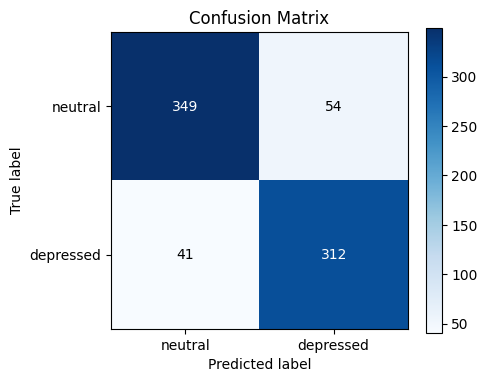

In [9]:
import os
import glob
import numpy as np
import torch
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Load model (adjust path and architecture as needed)
model = torch.load('efficientnetb3.pt', map_location=device)
model.to(device)
model.eval()

IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load test images
test_folder = 'calmscope_black_white/test/images'
image_paths = glob.glob(os.path.join(test_folder, '*.jpg')) + glob.glob(os.path.join(test_folder, '*.png'))

def get_actual_label(path):
    fname = os.path.basename(path).lower()
    parent = os.path.basename(os.path.dirname(path)).lower()
    if 'negative' in fname or parent == 'negative': return 0
    if 'positive' in fname or parent == 'positive': return 1
    return None

all_labels = []
all_preds = []

for img_path in image_paths:
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)
    actual_label = get_actual_label(img_path)
    if actual_label is None:
        continue
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
    all_labels.append(actual_label)
    all_preds.append(pred)

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
classes = ["neutral", "depressed"]

plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()